# Exploring the effects of the clean air zone (CAZ) on air quality in Bristol

Bristol City Council introduced a CAZ, where certain types of vehicles were charged a daily fee to enter a specified area around the city centre, in November 2022 to attempt to meet government guidance on air quality.

In this project I investigate the success of this scheme in achieving these aims.

To quantify air quality, we examine the concentration of NO2 from momnitoring sites across Bristol in data made publicly available by Bristol City Council. As a guideline, government policy states that the annual mean concentration cannot legally exceed 40 μg/m3.

## Datasets and packages used:

The following data are used in this project:


Current and historical air quality data from a number of monitoring sites around Bristol:

Air_Quality_Continuous.csv (https://opendata.bristol.gov.uk/datasets/bcc::air-quality-continuous/about)


Annual NO2 levels from diffusion tube monitors:

Air_Quality_(NO2_diffusion_tube)_data.csv (https://opendata.bristol.gov.uk/datasets/air-quality-no2-diffusion-tube-data-1/about)


Dataset of all air monitoring sites around Bristol:

Air_Quality_Monitoring_Sites.csv (https://opendata.bristol.gov.uk/datasets/bcc::air-quality-monitoring-sites/about)


CAZ coordinates in geoJSON format:

Bristol CAZ 2021.geoJSON (https://www.waze.com//wiki/UnitedKingdom/Congestion_and_Clean_Air_Zones)

(All data downloaded on 26/09/23)

In [1]:
# Import relevant packages

%load_ext nb_black

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import json
from bng_latlon import OSGB36toWGS84
from shapely.geometry import Point

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<IPython.core.display.Javascript object>

## Temporal trends in NO2 concentration:

Firstly we import and cleanse the continuous air quality dataset:

In [61]:
# Import csv and check shape
air_quality = pd.read_csv("data/Air_Quality_Continuous.csv")
print("Shape before dropna: " + str(air_quality.shape))

# Remove rows with NaN Date_Time or NO2 and recheck shape
air_quality = air_quality.dropna(how="any", subset=["Date_Time", "NO2", "Site_ID"])
print("Shape after dropna: " + str(air_quality.shape))

# Convert Date_Time to datetime, some erroneous values outside allowed range so pass errors='coerce'
print(
    "\n Data types before to_datetime: \n"
    + str(air_quality[["Date_Time", "NO2", "Site_ID"]].dtypes)
)
air_quality["Date_Time"] = pd.to_datetime(air_quality["Date_Time"], errors="coerce")

# Convert Site ID to int
air_quality["Site_ID"] = air_quality["Site_ID"].astype(int)

print(
    "\n Data types after to_datetime: \n"
    + str(air_quality[["Date_Time", "NO2", "Site_ID"]].dtypes)
)


print(
    "\n Number of measurement sites: "
    + str(air_quality["Site_ID"].nunique())
    + "\n Earliest datetime: "
    + str(air_quality["Date_Time"].min())
    + "\n Latest datetime: "
    + str(air_quality["Date_Time"].max())
)

Shape before dropna: (1595983, 19)
Shape after dropna: (1457419, 19)

 Data types before to_datetime: 
Date_Time     object
NO2          float64
Site_ID      float64
dtype: object

 Data types after to_datetime: 
Date_Time    datetime64[ns, UTC]
NO2                      float64
Site_ID                    int64
dtype: object

 Number of measurement sites: 18
 Earliest datetime: 1993-01-04 00:00:00+00:00
 Latest datetime: 2023-09-21 20:00:00+00:00


<IPython.core.display.Javascript object>

Here we can see this dataset has only 18 measurement sites but has records spanning from 1993 to the current date, with a high degree of granularity indicated by the large number of rows.

To check for outliers, we plot the distribution of NO2 concentrations from all measurements:

/Users/henrysymons/opt/anaconda3/envs/CAZ_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



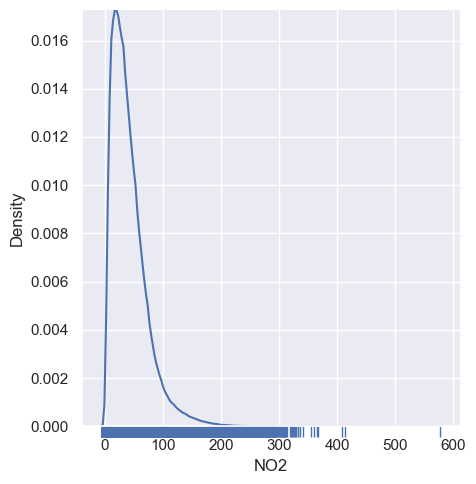

<IPython.core.display.Javascript object>

In [24]:
# Check for outliers in NO2
sns.set_theme(style="darkgrid")
g = sns.displot(x=air_quality["NO2"], kind="kde")
g = sns.rugplot(x=air_quality["NO2"], height=-0.025, clip_on=False)
plt.show()

We see the distribution of concentrations is predominantly between 0 and 200  μg/m3. There are individual concentrations as high as 600  μg/m3 shown by the rug plot, however these numbers are still plausible for temporal variations in concentration and so are not excluded in the analysis.

Next, we import and cleanse the diffusion tube air quality dataset:

In [92]:
# Import csv and check shape
air_quality_dif = pd.read_csv("data/Air_Quality_(NO2_diffusion_tube)_data.csv")
print("Shape before dropna: " + str(air_quality_dif.shape))

# Remove rows with NaN Date_Time or NO2 and recheck shape
air_quality_dif = air_quality_dif.dropna(
    how="any", subset=["Year_", "Concentration_ugm_3", "SiteID"]
)
print("Shape after dropna: " + str(air_quality_dif.shape))

print(
    "\n Number of measurement sites: "
    + str(air_quality_dif["SiteID"].nunique())
    + "\n Earliest year: "
    + str(air_quality_dif["Year_"].min())
    + "\n Latest year: "
    + str(air_quality_dif["Year_"].max())
)

Shape before dropna: (2743, 10)
Shape after dropna: (2743, 10)

 Number of measurement sites: 351
 Earliest year: 2010
 Latest year: 2022


<IPython.core.display.Javascript object>

The diffusion tube dataset contains yearly mean concentrations from 351 measurement sites. However, the time range of the data spans only from 2010 to 2022 so is not directly useful for assessing the effectiveness of the CAZ.

We can compare this dataset to the continuous air quality data, to ensure the smaller number of measurement sites are reflective of the overall trend in NO2 concentrations.

/var/folders/jr/q9pbf84j3834pdzq2jgg8ztm0000gn/T/ipykernel_95161/3233859895.py:18: UserWarning:

The label '_' of <matplotlib.collections.PolyCollection object at 0x7fa708242b50> starts with '_'. It is thus excluded from the legend.

/var/folders/jr/q9pbf84j3834pdzq2jgg8ztm0000gn/T/ipykernel_95161/3233859895.py:18: UserWarning:

The label '_' of <matplotlib.collections.PolyCollection object at 0x7fa708237be0> starts with '_'. It is thus excluded from the legend.



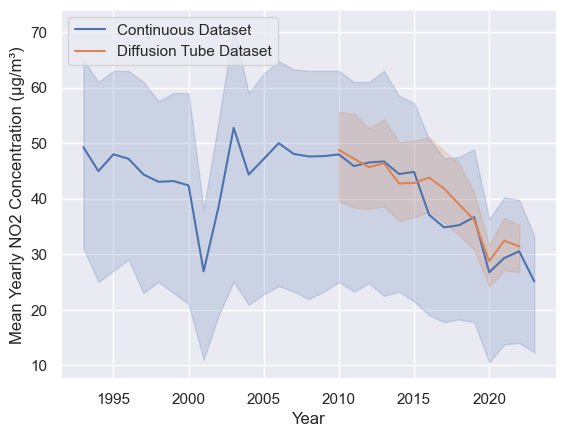

<IPython.core.display.Javascript object>

In [98]:
# Plot long-term trend in NO2 concentrations
g = sns.lineplot(
    x=air_quality["Date_Time"].dt.year,
    estimator="mean",
    errorbar=("pi", 50),
    y=air_quality["NO2"],
    # style=air_quality_locations["is_within_caz"],
)
g = sns.lineplot(
    x=air_quality_dif["Year_"],
    estimator="mean",
    errorbar=("pi", 50),
    y=air_quality_dif_locations["Concentration_ugm_3"],
    # style=air_quality_dif_locations["is_within_caz"],
)
g.set_ylabel("Mean Yearly NO2 Concentration (µg/m\u00b3)")
g.set_xlabel("Year")
plt.legend(
    title="",
    loc="upper left",
    labels=[
        "Continuous Dataset",
        "_",
        "Diffusion Tube Dataset",
        "_",
    ],
)
plt.savefig("longterm_no2_trends.png")
plt.show()

In this plot, we can see a very good agreement between both datasets between 2010 and 2022. This indicates that the subset of measurement sites in the continuous air quality dataset is a representative sample of the overall NO2 concentrations.

Overall, since the beginning of this dataset, we can see a steadily decreasing yearly concentration of NO2.

It's worth noting, however, that the data span 30+ years and are not consistent in terms of the locations and frequency measurements are conducted at. For example, it's not clear whether the sharp drop during the year 2001 is genuine or artefactual.

Using the continuous dataset we can explore other temporal trends in NO2 concentrations:

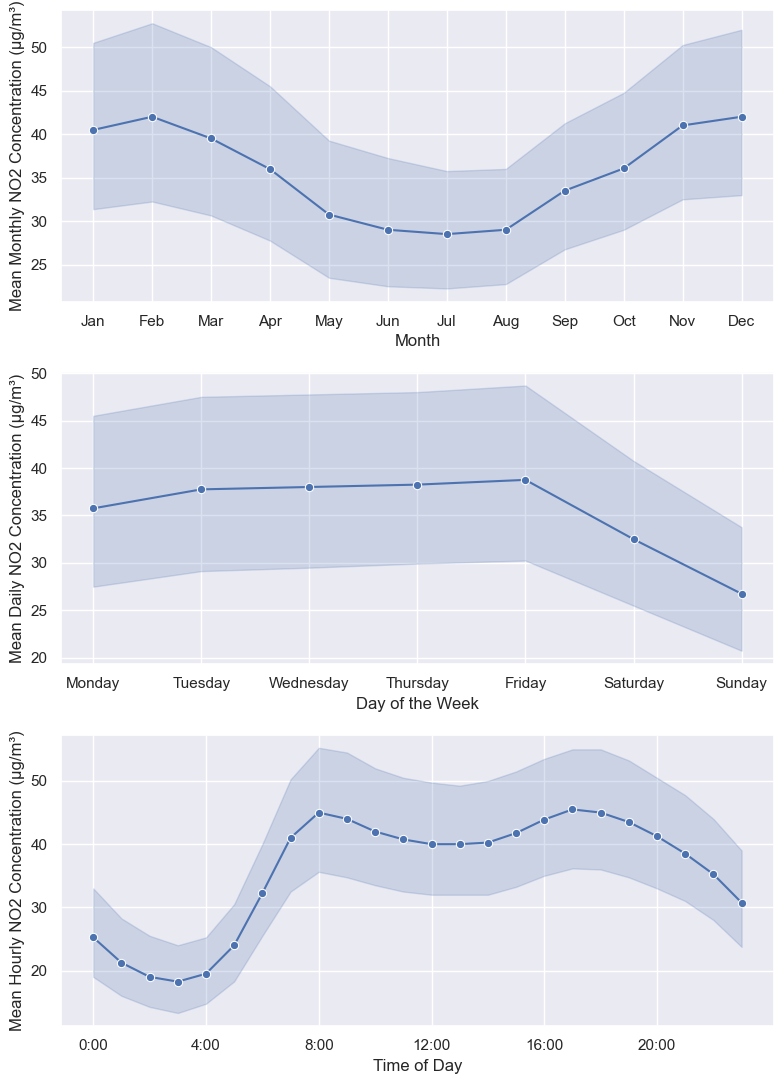

<IPython.core.display.Javascript object>

In [64]:
# Plotting periodic trends in NO2 concentrations:

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 11))

# Plot monthly trend in NO2 concentrations
sns.lineplot(
    x=air_quality["Date_Time"].dt.month,
    y=air_quality["NO2"],
    errorbar=("pi", 25),
    estimator="median",
    marker="o",
    ax=axes[0],
)
axes[0].set_ylabel("Mean Monthly NO2 Concentration (µg/m³)")
axes[0].set_xlabel("Month")
axes[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axes[0].set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

# Plot daily trend in NO2 concentrations
sns.lineplot(
    x=air_quality["Date_Time"].dt.day_name(),
    y=air_quality["NO2"],
    errorbar=("pi", 25),
    estimator="median",
    marker="o",
    ax=axes[1],
)
axes[1].set_ylabel("Mean Daily NO2 Concentration (µg/m³)")
axes[1].set_xlabel("Day of the Week")

# Plot hourly trend in NO2 concentrations
sns.lineplot(
    x=air_quality["Date_Time"].dt.hour,
    y=air_quality["NO2"],
    errorbar=("pi", 25),
    estimator="median",
    marker="o",
    ax=axes[2],
)
axes[2].set_ylabel("Mean Hourly NO2 Concentration (µg/m³)")
axes[2].set_xlabel("Time of Day")
axes[2].set_xticks([0, 4, 8, 12, 16, 20])
axes[2].set_xticklabels(["0:00", "4:00", "8:00", "12:00", "16:00", "20:00"])

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.savefig("periodic_no2_trends.png")
plt.show()

Here we can see several periodic trends in NO2 concentrations:

Firstly, we see a pretty substantial seasonal effect with levels highest during winter, but decreasing by approximately a quarter during the summer months. This behaviour is well documented and could indicate both a change in use (e.g. more heating or engine idling during colder months) and a seasonal difference in the pollutant lifetimes (which are shortest during summer months).

Secondly, we see a clear pattern associated with typical vehicle usage - a gradual build up during consecutive weekdays, with a substantial drop on weekends.

Looking on a shorter timescale, mean hourly concentrations peak at over 50 µg/m3 between 8-9 am and 5-6 pm, strongly coinciding with typical commuting times. Notably, overnight NO2 levels decrease to less than half the daytime maxima, showing the relatively short lifetime of this pollutant.

## Exploring the spatial distribution of measurement sites and the CAZ

Load "Air_Quality_Monitoring_Sites.csv", and convert measurement location coordinates from Easting/Northing to Latitude/Longditude:

In [89]:
# Import csv file:
monitoring_sites = pd.read_csv("data/Air_Quality_Monitoring_Sites.csv")

# Convert location coordinates to latitude/longditude:
monitoring_sites["latlon"] = monitoring_sites.apply(
    lambda row: OSGB36toWGS84(row["Easting"], row["Northing"]), axis=1
)
monitoring_sites[["lat", "lon"]] = monitoring_sites["latlon"].apply(pd.Series)


# Label sites depending on which dataset they appear in:
def dataset_map(row):
    value = row["SiteID"]
    if value in air_quality["Site_ID"].values:
        return "Continuous Dataset"
    if value in air_quality_dif["SiteID"].values:
        return "Diffusion Tube Dataset"
    else:
        return "No Dataset"


monitoring_sites["dataset"] = monitoring_sites.apply(dataset_map, axis=1)

<IPython.core.display.Javascript object>

Load the CAZ and check which measurement sites lie within it:

In [90]:
# Load the GeoJSON file into a GeoDataFrame:
gdf_caz = gpd.read_file("Data/Bristol CAZ 2021.geojson")

# Create shapely.geometry.Point objects for each coordinate in DataFrame:
geometry = [
    Point(lon, lat)
    for lon, lat in zip(monitoring_sites["lon"], monitoring_sites["lat"])
]

# Create a new GeoDataFrame from the DataFrame and the Point objects:
gdf_monitoring_sites = gpd.GeoDataFrame(
    monitoring_sites, geometry=geometry, crs=gdf_caz.crs
)

# Use the GeoDataFrame's "within" method to check if points are within the polygon:
gdf_monitoring_sites["is_within_caz"] = gdf_monitoring_sites["geometry"].within(
    gdf_caz.unary_union
)

<IPython.core.display.Javascript object>

Plot measurement site locations and type (i.e. NO2 data present or not, and inside or outside CAZ):

In [103]:
# Load CAZ coordinates from geojson file:
with open("Data/Bristol CAZ 2021.geojson", "r") as geojson_file:
    geojson_data = json.load(geojson_file)

# Plot monitoring sites with colour indicating points inside/outside CAZ:
fig = px.scatter_mapbox(
    gdf_monitoring_sites,
    lon="lon",
    lat="lat",
    zoom=11,
    height=450,
    width=550,
    hover_name="SiteID",
    opacity=0.75,
    color="is_within_caz",
    animation_frame="dataset",
    color_discrete_sequence=px.colors.qualitative.Vivid,
)
fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 0, "l": 0, "b": 100},
    legend_title="Inside CAZ?",
)

# Plot CAZ on same map:
# nb. geojson file contains multiple polygons, therefore a for loop is used.
for feature in geojson_data["features"]:
    fig.update_layout(
        mapbox={
            "layers": [
                {
                    "source": geojson_data,
                    "type": "fill",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.3,
                },
                {
                    "source": geojson_data,
                    "type": "line",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.8,
                },
            ]
        }
    )

fig["layout"].pop("updatemenus")
fig.update_layout(sliders=[{"currentvalue": {"prefix": "Associated Data="}}])
fig["layout"]["sliders"][0]["pad"] = dict(r=30, t=20)
fig.show()

import plotly.io as pio

pio.write_html(
    fig,
    file="measurement_sites_bristol.html",
    auto_open=False,
    default_width="70%",
    default_height="70%",
)

<IPython.core.display.Javascript object>

From this initial map, we can see that although there are several hundred air quality monitoring sites around Bristol, only a small subset are included in the continuous air quality dataset. The remaining sites are either included in the diffusion tube dataset, or are associated with other datasets not included in this project (marked here as 'No Dataset').

However, of the sites included in the continuous dataset, there are several both inside and outside the CAZ, which should be sufficient to enable an exploratory analysis of the success of the CAZ.

## Mapping NO2 Concentrations

To understand the spatial and temporal distribution of NO2 concentrations we can merge our air quality datasets with the monitoring sites dataframe and map NO2 concentration as a function of time.

In [9]:
# Merge with locations df:
air_quality_locations = pd.merge(
    air_quality, gdf_monitoring_sites, left_on="Site_ID", right_on="SiteID", how="left"
)

<IPython.core.display.Javascript object>

In [10]:
# Calculate yearly average NO2, grouped by Site_ID:
no2_by_year = (
    air_quality_locations.groupby(
        [air_quality_locations["Site_ID"], air_quality_locations["Date_Time"].dt.year]
    )
    .agg(mean_no2=("NO2", "mean"), lat=("lat", "median"), lon=("lon", "median"))
    .reset_index()
    .sort_values("Date_Time")
)

# Plot monitoring sites with colour and size indicating annual NO2 concentration:
fig = px.scatter_mapbox(
    no2_by_year,
    lon="lon",
    lat="lat",
    zoom=11,
    #     height=450,
    #     width=750,
    height=450,
    width=550,
    hover_name="Site_ID",
    opacity=0.5,
    color="mean_no2",
    size="mean_no2",
    animation_frame=no2_by_year["Date_Time"].astype(int),
    range_color=(0, 80),
    template="plotly",
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 50, "l": 0, "b": 100},
    coloraxis_colorbar_title_text="NO2<br>(µg/m³)",
    sliders=[{"currentvalue": {"prefix": "Year="}}],
    title="Annual Mean NO2 Concentration by Measurement Site",
)

# Plot CAZ on same map:
for feature in geojson_data["features"]:
    fig.update_layout(
        mapbox={
            "layers": [
                {
                    "source": geojson_data,
                    "type": "fill",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.2,
                },
                {
                    "source": geojson_data,
                    "type": "line",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.6,
                },
            ]
        },
    )

fig["layout"]["updatemenus"][0]["pad"] = dict(r=20, t=40)
fig["layout"]["sliders"][0]["pad"] = dict(r=-10, t=20)
fig.show()

import plotly.io as pio

pio.write_html(
    fig,
    file="no2_historic_bristol.html",
    auto_open=False,
    default_width="70%",
    default_height="70%",
)

<IPython.core.display.Javascript object>

In this animation we see an overall trend of decreasing NO2 concentration in Bristol over the past 30 years.

This plot also highlights the limitations of this dataset, with the number of measurement sites included in each year varying considerably. In fact, looking at the year 2001, we see that the previously noted drop in NO2 seems to be caused by a change in measurement sites, exacerbated by the relatively small number of locations included earlier in the dataset.

Although not strictly relevant to this project, a more complete animated map for the years 2010-2022 can be plotted using the diffusion tube dataset:

In [100]:
air_quality_dif_locations = air_quality_dif_locations.sort_values(
    "Year_", ascending=True
)

# Plot monitoring sites with colour and size indicating annual NO2 concentration:
fig = px.scatter_mapbox(
    air_quality_dif_locations,
    lon="lon",
    lat="lat",
    zoom=11,
    height=450,
    width=550,
    hover_name="SiteID",
    opacity=0.5,
    color="Concentration_ugm_3",
    size="Concentration_ugm_3",
    animation_frame="Year_",
    range_color=(0, 80),
    template="plotly",
    size_max=10,
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 50, "l": 0, "b": 100},
    coloraxis_colorbar_title_text="NO2<br>(µg/m³)",
    sliders=[{"currentvalue": {"prefix": "Year="}}],
    title="Annual Mean NO2 Concentration by Measurement Site",
)

# Plot CAZ on same map:
for feature in geojson_data["features"]:
    fig.update_layout(
        mapbox={
            "layers": [
                {
                    "source": geojson_data,
                    "type": "fill",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.2,
                },
                {
                    "source": geojson_data,
                    "type": "line",
                    "below": "traces",
                    "color": "rgb(36, 121, 108)",
                    "opacity": 0.6,
                },
            ]
        },
    )

fig["layout"]["updatemenus"][0]["pad"] = dict(r=20, t=40)
fig["layout"]["sliders"][0]["pad"] = dict(r=-10, t=20)
fig.show()

import plotly.io as pio

pio.write_html(
    fig,
    file="no2_diffusion_bristol.html",
    auto_open=False,
    default_width="70%",
    default_height="70%",
)

<IPython.core.display.Javascript object>

## Quantifying the effects of the CAZ on NO2 concentrations

Given the stability in measurement sites, to investigate the success of the CAZ, we will focus on data reported from one year before the introduction of CAZ and onwards,  where the number/locations of measurement sites remains consistent.

This time period should also limit the influence of other factors (e.g. the effects of intermittent COVID-19 measures during 2020 and 2021).

In [85]:
# Filter data from 1 year before CAZ
air_quality_2021_onwards = air_quality_locations[
    air_quality_locations["Date_Time"] >= "2021-11-28"  # .dt.year >= 2021
]

# Aggregate data by week
no2_by_week = (
    air_quality_2021_onwards.groupby(
        [
            air_quality_2021_onwards["lat"],
            air_quality_2021_onwards["lon"],
            pd.Grouper(key="Date_Time", freq="W"),
        ]
    )
    .agg(
        mean_no2=("NO2", "mean"),
        site_ID=("SiteID", "median"),
        in_CAZ=("is_within_caz", "median"),
    )
    .reset_index()
)

# Add additional columns to weekly df for plotting
no2_by_week["Month"] = no2_by_week["Date_Time"].dt.month
no2_by_week["Year"] = no2_by_week["Date_Time"].dt.year
no2_by_week["period"] = (no2_by_week["Date_Time"] >= "2022-11-28").map(
    {False: "pre CAZ", True: "post CAZ"}
)

<IPython.core.display.Javascript object>

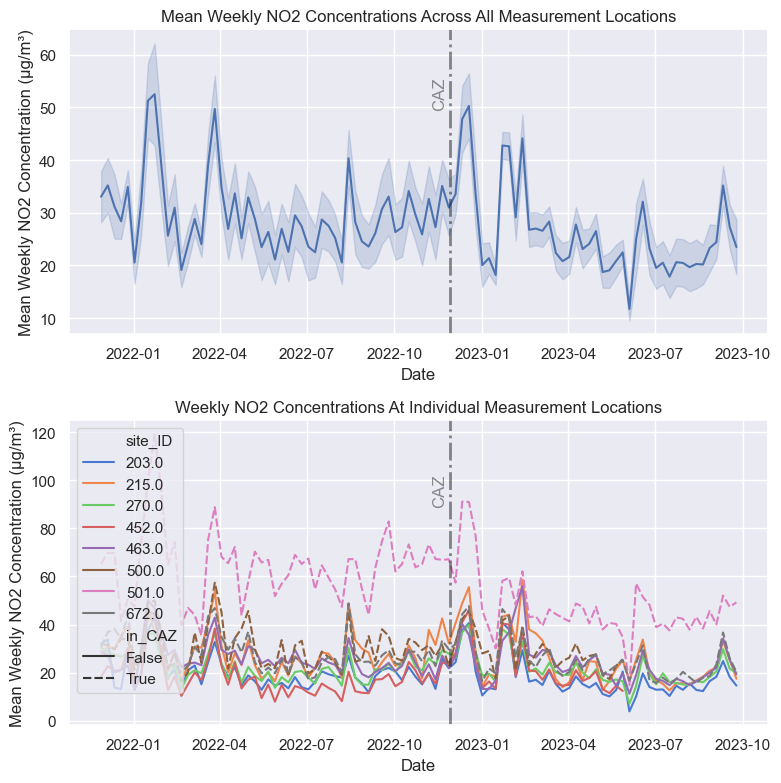

<IPython.core.display.Javascript object>

In [86]:
# Create a figure with three subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot weekly trend in NO2 concentrations
sns.lineplot(
    data=no2_by_week,
    x="Date_Time",
    y="mean_no2",
    errorbar="se",
    ax=axes[0],
)
axes[0].set_ylabel("Mean Weekly NO2 Concentration (µg/m³)")
axes[0].set_xlabel("Date")
axes[0].set_title("Mean Weekly NO2 Concentrations Across All Measurement Locations")
axes[0].axvline(pd.Timestamp("2022-11-28"), ls="-.", linewidth=2, alpha=0.5, color="k")
axes[0].text(pd.Timestamp("2022-11-10"), 50, "CAZ", rotation=90, alpha=0.5)

# Plot daily trend in NO2 concentrations
sns.lineplot(
    data=no2_by_week,
    x="Date_Time",
    y="mean_no2",
    hue="site_ID",
    style=no2_by_week["in_CAZ"].map({0: "False", 1: "True"}),
    palette="muted",
    ax=axes[1],
)
axes[1].set_ylabel("Mean Weekly NO2 Concentration (µg/m³)")
axes[1].set_xlabel("Date")
axes[1].set_title("Weekly NO2 Concentrations At Individual Measurement Locations")
axes[1].axvline(pd.Timestamp("2022-11-28"), ls="-.", linewidth=2, alpha=0.5, color="k")
axes[1].text(pd.Timestamp("2022-11-10"), 90, "CAZ", rotation=90, alpha=0.5)
sns.move_legend(axes[1], loc="upper left")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.savefig("timeseries.png")
plt.show()

Here we see weekly mean NO2 concentrations, averaged across all measurement sites in the dataset, and the same data plotted individually for each site.

Looking at the averaged data, weekly concentrations fluctuate significantly making longer-term changes unclear, however, there appears to be slight long-term decrease in NO2 after the introduction of the CAZ.

Looking at individual sites, we see that most remain unchanged, however one site within the CAZ (site ID 501) shows a substantial decrease in NO2 measured.

/Users/henrysymons/opt/anaconda3/envs/CAZ_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



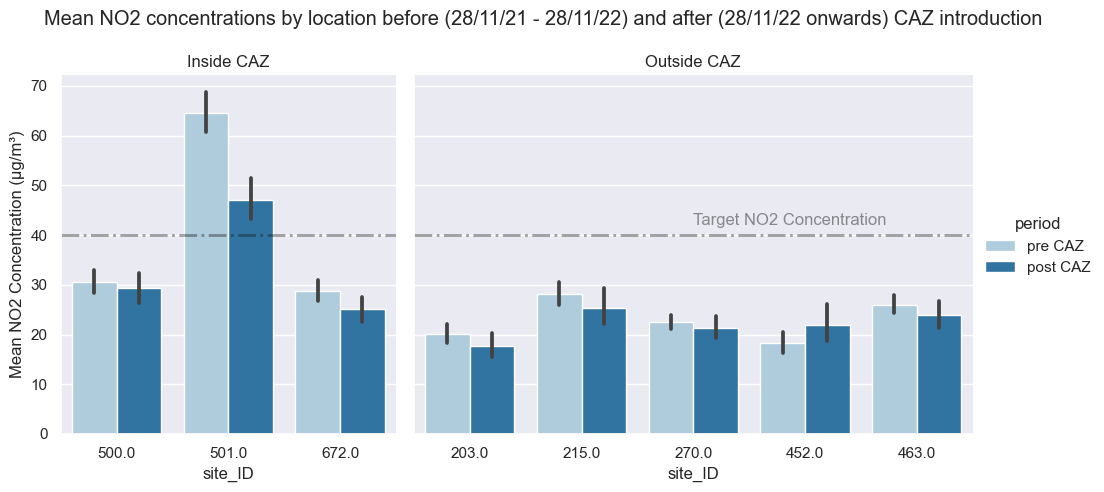

<IPython.core.display.Javascript object>

In [87]:
g = sns.catplot(
    kind="bar",
    data=no2_by_week,
    x="site_ID",
    y="mean_no2",
    hue="period",
    col="in_CAZ",
    col_order=[True, False],
    palette="Paired",
    facet_kws={
        "gridspec_kws": {
            "width_ratios": 1
            / (no2_by_week.groupby("in_CAZ")["site_ID"].nunique().values)
        }
    },
    sharex=False,
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(
    "Mean NO2 concentrations by location before (28/11/21 - 28/11/22) and after (28/11/22 onwards) CAZ introduction"
)
ax1, ax2 = g.axes[0]
ax1.set_ylabel("Mean NO2 Concentration (µg/m³)")
ax1.axhline(40, ls="-.", label="Target NO2", linewidth=2, alpha=0.4, color="k")
ax2.axhline(40, ls="-.", label="Target NO2", linewidth=2, alpha=0.4, color="k")
ax2.text(2, 42, "Target NO2 Concentration", rotation=0, alpha=0.5)
ax1.set_title("Inside CAZ")
ax2.set_title("Outside CAZ")

plt.savefig("barplot.png")
plt.show()

To see these changes more clearly, mean NO2 concentrations are plotted before and after the introduction of the CAZ for each site.

In this plot we can clearly see that all locations within the CAZ have experienced a reduction in mean NO2 concentration, when compared with the year prior to its introduction. In particular, the site with highest NO2 concentrations (site ID 501) has shown a substantial drop and is now close to the target level of 40 µg/m3.

/Users/henrysymons/opt/anaconda3/envs/CAZ_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



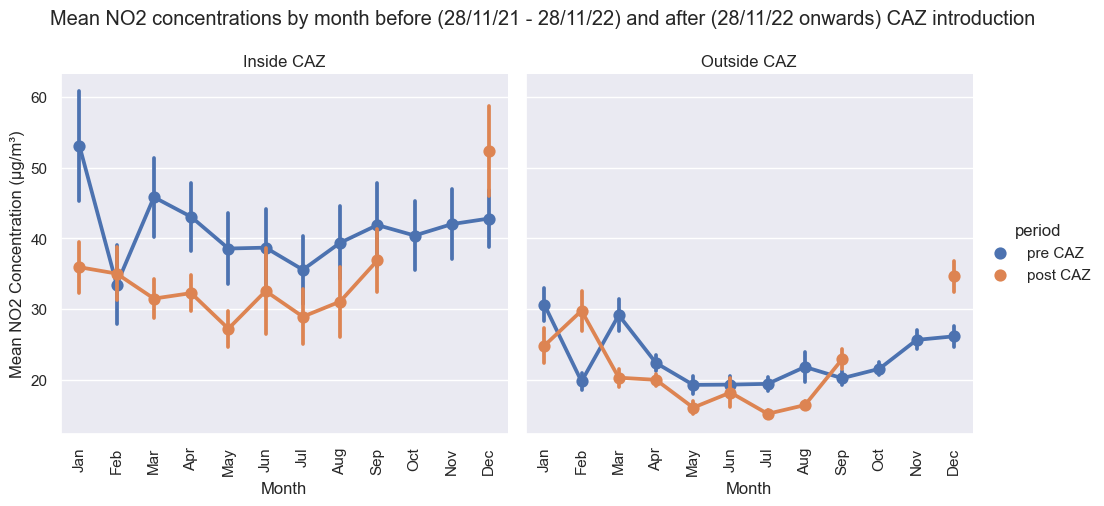

<IPython.core.display.Javascript object>

In [101]:
# Plot the responses for different events and regions
no2_by_week["in_CAZ_str"] = no2_by_week["in_CAZ"].map(
    {0: "Outside CAZ", 1: "Inside CAZ"}
)

g = sns.catplot(
    kind="point",
    data=no2_by_week,
    x="Month",
    y="mean_no2",
    errorbar="se",
    hue="period",
    col="in_CAZ_str",
    col_order=["Inside CAZ", "Outside CAZ"],
    #     row="site_ID",
)
g.tick_params(axis="x", rotation=90)
g.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
g.set_ylabels("Mean NO2 Concentration (µg/m³)")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(
    "Mean NO2 concentrations by month before (28/11/21 - 28/11/22) and after (28/11/22 onwards) CAZ introduction"
)
plt.savefig("caz_bymonth.png")
plt.show()

One final check in this exploratory analysis is to confirm that differences are not simply a result of seasonal variation in NO2, as a full year has not yet passed since the introduction of the CAZ.

In these plots, we compare NO2 concentrations by month, averaged over sites either inside or outside the CAZ. We see that for almost all months, sites inside the CAZ have experienced a substantial decrease in NO2 concentration compared with the same months before the CAZ introduction.

## Conclusions

Overall, this preliminary analysis appears to indicate that the introduction of the CAZ has been successful in improving air quality around Bristol city centre. All measurement locations within the CAZ have recorded lower NO2 concentrations since the introduction of the scheme. Significantly, the site with the highest concentration the year prior to CAZ introduction (around 64  μg/m3) has since recorded a number much closer to the legal limit (around 47  μg/m3). The observed decreases do no appear to be a result of seasonal changes in NO2 concentrations.

A more comprehensive dataset with a greater number of measurement sites, and additional time passing since the introduction of the scheme will enable more extensive analysis of the effects of the CAZ. For example, an updated diffusion tube dataset containing data for 2023 should allow further insight and quantification of the changes seen.